Combines frozen YAMNet + Scaler + Classifier → TensorFlow SavedModel

Supports: LogisticRegression (TF ops), Others → Keras MLP (retrained)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
import warnings

warnings.filterwarnings('ignore')

# -------------------------- PATHS --------------------------
MODELS_DIR       = '../models/models_approach1'
RESULTS_DIR      = '../results/results_approach1'
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, 'saved_models')
YAMNET_URL       = 'https://tfhub.dev/google/yamnet/1'
FEATURES_DIR     = '../data/approach1/features'

os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR,    exist_ok=True)

c:\Users\301364822\AppData\Local\miniconda3\envs\AI-Capstone-FINAL\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# -------------------------- LOAD COMPONENTS --------------------------
label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
scaler        = joblib.load(os.path.join(MODELS_DIR, 'feature_scaler.pkl'))
comparison_df = pd.read_csv(os.path.join(RESULTS_DIR, 'model_comparison.csv'))

# Load YAMNet once – shared by every full model
yamnet = hub.load(YAMNET_URL)
print("YAMNet loaded")

# -------------------------- LOAD FEATURES --------------------------
print("\nLoading train / val features …")
X_train = np.load(os.path.join(FEATURES_DIR, 'train', 'yamnet_features.npy'))
y_train = np.load(os.path.join(FEATURES_DIR, 'train', 'yamnet_labels.npy'))
X_val   = np.load(os.path.join(FEATURES_DIR, 'val',   'yamnet_features.npy'))
y_val   = np.load(os.path.join(FEATURES_DIR, 'val',   'yamnet_labels.npy'))

y_train_enc = label_encoder.transform(y_train)
y_val_enc   = label_encoder.transform(y_val)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
print("Features scaled")

YAMNet loaded

Loading train / val features …
Features scaled


In [3]:
# -------------------------- TEMPERATURE CALIBRATION --------------------------
def calibrate_temperature(logits: np.ndarray, true_labels: np.ndarray) -> float:
    def nll(T):
        scaled = logits / T
        log_probs = tf.nn.log_softmax(scaled).numpy()
        true_log_probs = log_probs[np.arange(len(true_labels)), true_labels]
        return -np.mean(true_log_probs)

    res = optimize.minimize_scalar(nll, bounds=(0.01, 10.0), method='bounded')
    return float(res.x)

# -------------------------- CUSTOM YAMNET LAYER --------------------------
@tf.keras.utils.register_keras_serializable()
class YamnetEmbedding(tf.keras.layers.Layer):
    def __init__(self, yamnet_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model = yamnet_model

    def call(self, inputs):
        def _single(wave):
            _, embeddings, _ = self.yamnet_model(wave)
            return tf.reduce_mean(embeddings, axis=0)          # (1024,)
        return tf.map_fn(_single, inputs, dtype=tf.float32)

# -------------------------- BUILD / CONVERT CLASSIFIERS --------------------------
print("\n=== BUILDING KERAS CLASSIFIERS (logits) ===")

keras_classifiers = {}   # <-- ONLY KERAS objects go here
temperatures      = {}
results_comparison = []

# Iterate through the Leaderboard
for name in comparison_df['Model']:
    print(f"\n→ Processing: {name}")
    
    # --- CASE 1: The Winning Neural Network ---
    if name == 'Custom_Keras_NN':
        print("  Loading existing High-Performance Keras model...")
        # Load the .h5 file directly
        keras_model = load_model(os.path.join(MODELS_DIR, 'custom_keras_nn.h5'))
        
        # We need to remove the Softmax layer if it exists to get Logits, 
        # OR we just use the model as is if it outputs logits (which ours does: from_logits=True)
        # Our previous training code outputted Logits (no activation in last layer).
        # So we can use it directly.
        
        # Get original metrics
        val_logits = keras_model.predict(X_val_scaled, verbose=0)
        orig_pred  = np.argmax(val_logits, axis=1)
        orig_acc   = accuracy_score(y_val_enc, orig_pred)
        orig_f1    = f1_score(y_val_enc, orig_pred, average='macro')
        
        # For uniformity in the loop
        mlp_acc = orig_acc
        mlp_f1  = orig_f1
        
    # --- CASE 2: Scikit-Learn Models (Need Conversion) ---
    else:
        # Load the sklearn pickle
        path = os.path.join(MODELS_DIR, f'{name.lower()}_model.pkl')
        clf = joblib.load(path)
        
        # Original sklearn performance
        orig_pred = clf.predict(X_val_scaled)
        orig_acc  = accuracy_score(y_val_enc, orig_pred)
        orig_f1   = f1_score(y_val_enc, orig_pred, average='macro')
        print(f"  Original sklearn | Acc: {orig_acc:.4f} | F1: {orig_f1:.4f}")

        if isinstance(clf, LogisticRegression):
            # Exact replica of the LR (logits only)
            print("  Converting Logistic Regression weights...")
            inputs = Input(shape=(X_train_scaled.shape[1],))
            logits = Dense(
                len(label_encoder.classes_),
                kernel_initializer=tf.constant_initializer(clf.coef_.T),
                bias_initializer=tf.constant_initializer(clf.intercept_),
                name='logits'
            )(inputs)
            keras_model = Model(inputs, logits)
            
            # Verify performance matches exact
            val_logits = keras_model.predict(X_val_scaled, verbose=0)
            mlp_pred   = np.argmax(val_logits, axis=1)
            mlp_acc    = accuracy_score(y_val_enc, mlp_pred)
            mlp_f1     = f1_score(y_val_enc, mlp_pred, average='macro')

        else:
            # RF / XGB / SVM -> Train a "Surrogate" MLP
            # We train a fresh MLP to approximate the tree models for TF deployment
            print(f"  Training surrogate Keras MLP to replace {name}...")
            mlp = Sequential([
                Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
                Dropout(0.3),
                Dense(256, activation='relu'),
                Dropout(0.2),
                Dense(len(label_encoder.classes_), activation=None)   # logits
            ])
            mlp.compile(
                optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
            )
            mlp.fit(
                X_train_scaled, y_train_enc,
                epochs=20, batch_size=64,
                validation_data=(X_val_scaled, y_val_enc),
                verbose=0
            )
            keras_model = mlp
            
            # Surrogate performance
            val_logits = keras_model.predict(X_val_scaled, verbose=0)
            mlp_pred   = np.argmax(val_logits, axis=1)
            mlp_acc    = accuracy_score(y_val_enc, mlp_pred)
            mlp_f1     = f1_score(y_val_enc, mlp_pred, average='macro')
            print(f"  Surrogate MLP    | Acc: {mlp_acc:.4f} | F1: {mlp_f1:.4f}")

    # Store for next step
    keras_classifiers[name] = keras_model

    # ---- Temperature calibration ----
    # Ensure logits are computed (Case 1 already did it, Case 2 converted/trained)
    if name != 'Custom_Keras_NN' and not isinstance(clf, LogisticRegression): 
         val_logits = keras_model.predict(X_val_scaled, verbose=0)

    T = calibrate_temperature(val_logits, y_val_enc)
    temperatures[name] = T
    print(f"  Calibrated T = {T:.3f}")

    # ---- Store comparison ----
    results_comparison.append({
        'Model'        : name,
        'Original_Acc' : round(orig_acc, 4),
        'Original_F1'  : round(orig_f1,  4),
        'MLP_Acc'      : round(mlp_acc, 4),
        'MLP_F1'       : round(mlp_f1,  4),
        'Temperature'  : round(T, 3)
    })


=== BUILDING KERAS CLASSIFIERS (logits) ===

→ Processing: Custom_Keras_NN
  Loading existing High-Performance Keras model...



  Calibrated T = 0.776

→ Processing: XGBoost
  Original sklearn | Acc: 0.8325 | F1: 0.8273
  Training surrogate Keras MLP to replace XGBoost...



  Surrogate MLP    | Acc: 0.8350 | F1: 0.8270
  Calibrated T = 6.086

→ Processing: Random_Forest
  Original sklearn | Acc: 0.8289 | F1: 0.8238
  Training surrogate Keras MLP to replace Random_Forest...
  Surrogate MLP    | Acc: 0.8362 | F1: 0.8295
  Calibrated T = 5.175

→ Processing: SVM
  Original sklearn | Acc: 0.8107 | F1: 0.8086
  Training surrogate Keras MLP to replace SVM...
  Surrogate MLP    | Acc: 0.8216 | F1: 0.8161
  Calibrated T = 4.995

→ Processing: Logistic_Regression
  Original sklearn | Acc: 0.8022 | F1: 0.7970
  Converting Logistic Regression weights...
  Calibrated T = 4.064



              Model  Original_Acc  Original_F1  MLP_Acc  MLP_F1  Temperature
    Custom_Keras_NN        0.8629       0.8567   0.8629  0.8567        0.776
            XGBoost        0.8325       0.8273   0.8350  0.8270        6.086
      Random_Forest        0.8289       0.8238   0.8362  0.8295        5.175
                SVM        0.8107       0.8086   0.8216  0.8161        4.995
Logistic_Regression        0.8022       0.7970   0.8022  0.7970        4.064


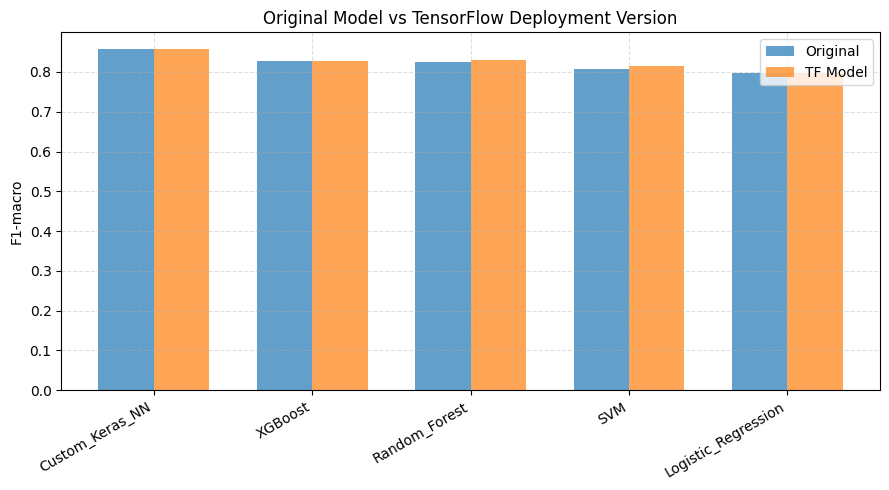

In [4]:
# -------------------------- COMPARISON TABLE & PLOT --------------------------
comp_df = pd.DataFrame(results_comparison)
print("\n" + comp_df.to_string(index=False))
comp_df.to_csv(os.path.join(RESULTS_DIR, 'classifier_vs_replacement_comparison.csv'), index=False)

plt.figure(figsize=(9, 5))
x = np.arange(len(comp_df))
width = 0.35
plt.bar(x - width/2, comp_df['Original_F1'], width, label='Original', alpha=0.7)
plt.bar(x + width/2, comp_df['MLP_F1'],     width, label='TF Model', alpha=0.7)
plt.xticks(x, comp_df['Model'], rotation=30, ha='right')
plt.ylabel('F1-macro')
plt.title('Original Model vs TensorFlow Deployment Version')
plt.legend()
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [6]:
# -------------------------- CUSTOM LAYERS (FIX FOR SERIALIZATION) --------------------------
@tf.keras.utils.register_keras_serializable()
class ScalerLayer(tf.keras.layers.Layer):
    """
    Applies (x - mean) / scale. 
    Stores mean and scale as non-trainable weights to ensure serialization works.
    """
    def __init__(self, mean, scale, **kwargs):
        super(ScalerLayer, self).__init__(**kwargs)
        self.mean_val = mean
        self.scale_val = scale
        # Define as weights so they are saved with the model graph
        self.mean_weight = tf.Variable(initial_value=mean, trainable=False, dtype=tf.float32, name="scaler_mean")
        self.scale_weight = tf.Variable(initial_value=scale, trainable=False, dtype=tf.float32, name="scaler_scale")

    def call(self, inputs):
        return (inputs - self.mean_weight) / self.scale_weight

    def get_config(self):
        config = super(ScalerLayer, self).get_config()
        # We store the values in config as lists so they can be JSON serialized
        config.update({
            "mean": self.mean_val.tolist() if hasattr(self.mean_val, 'tolist') else self.mean_val,
            "scale": self.scale_val.tolist() if hasattr(self.scale_val, 'tolist') else self.scale_val
        })
        return config

@tf.keras.utils.register_keras_serializable()
class TemperatureSoftmax(tf.keras.layers.Layer):
    """
    Applies softmax(x / T).
    """
    def __init__(self, temperature=1.0, **kwargs):
        super(TemperatureSoftmax, self).__init__(**kwargs)
        self.temperature = float(temperature)

    def call(self, inputs):
        return tf.nn.softmax(inputs / self.temperature)

    def get_config(self):
        config = super(TemperatureSoftmax, self).get_config()
        config.update({"temperature": self.temperature})
        return config

# -------------------------- BUILD FULL END-TO-END MODELS --------------------------
def build_full_model(keras_classifier, name: str, T: float) -> tf.keras.Model:
    """YAMNet -> scaling -> Keras classifier -> temperature-scaled softmax."""
    # Input is raw audio waveform (15360 samples = 0.96s @ 16kHz)
    audio_in = Input(shape=(15360,), dtype=tf.float32, name='audio')

    # 1. YAMNet embeddings
    # Note: We assume YamnetEmbedding is defined as per your previous block
    emb = YamnetEmbedding(yamnet)(audio_in)                 # (batch, 1024)

    # 2. Standard-scale (Using Custom Layer to fix serialization)
    # We pass the raw numpy arrays from the scaler
    scaled = ScalerLayer(mean=scaler.mean_, scale=scaler.scale_)(emb)

    # 3. Classifier – **always the Keras object**
    logits = keras_classifier(scaled)

    # 4. Temperature scaling + softmax (Using Custom Layer)
    probs = TemperatureSoftmax(temperature=T, name='probs')(logits)

    return Model(audio_in, probs, name=name)

# -------------------------- SAVE ALL FULL MODELS --------------------------
saved_paths = {}
for name in keras_classifiers.keys():
    T          = temperatures[name]
    keras_clf  = keras_classifiers[name]          # <-- ONLY KERAS HERE
    print(f"\nBuilding SavedModel for {name} (T={T:.3f})")
    full_model = build_full_model(keras_clf, name, T)

    # sanity check
    dummy = np.random.randn(1, 15360).astype(np.float32)
    out   = full_model.predict(dummy, verbose=0)
    print(f"  probs sum = {out.sum():.4f}")

    save_dir = os.path.join(SAVED_MODELS_DIR, f'{name.lower()}_full')
    full_model.save(save_dir, save_format='tf')
    saved_paths[name] = save_dir
    print(f"  Saved -> {save_dir}")

# -------------------------- VERIFY LOADING --------------------------
print("\nVerifying SavedModels ...")
for name, p in saved_paths.items():
    # When loading, we must provide the custom classes
    loaded = tf.keras.models.load_model(
        p,
        custom_objects={
            'YamnetEmbedding': YamnetEmbedding,
            'ScalerLayer': ScalerLayer,
            'TemperatureSoftmax': TemperatureSoftmax
        }
    )
    test_out = loaded.predict(np.random.randn(1, 15360).astype(np.float32), verbose=0)
    print(f"{name}: OK - probs sum = {test_out.sum():.4f}")

# -------------------------- INVENTORY (size) --------------------------
def dir_size_mb(path: str) -> float:
    total = 0.0
    for root, _, files in tf.io.gfile.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            total += tf.io.gfile.stat(fp).length
    return total / (1024 * 1024)

inventory = []
for _, row in comp_df.iterrows():
    name = row['Model']
    if name in saved_paths:
        size = dir_size_mb(saved_paths[name])
        inventory.append({
            'Model'   : name,
            'Val_F1'  : row['MLP_F1'],
            'Path'    : saved_paths[name],
            'Size_MB' : f"{size:.1f}"
        })

inv_df = pd.DataFrame(inventory).sort_values('Val_F1', ascending=False)
print("\n=== FULL-MODEL INVENTORY ===")
print(inv_df.to_string(index=False))
inv_df.to_csv(os.path.join(RESULTS_DIR, 'full_model_inventory.csv'), index=False)


Building SavedModel for Custom_Keras_NN (T=0.776)
  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\custom_keras_nn_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\custom_keras_nn_full\assets


  Saved -> ../models/models_approach1\saved_models\custom_keras_nn_full

Building SavedModel for XGBoost (T=6.086)
  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\xgboost_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\xgboost_full\assets


  Saved -> ../models/models_approach1\saved_models\xgboost_full

Building SavedModel for Random_Forest (T=5.175)


  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\random_forest_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\random_forest_full\assets


  Saved -> ../models/models_approach1\saved_models\random_forest_full

Building SavedModel for SVM (T=4.995)


  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\svm_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\svm_full\assets


  Saved -> ../models/models_approach1\saved_models\svm_full

Building SavedModel for Logistic_Regression (T=4.064)
  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\logistic_regression_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\logistic_regression_full\assets


  Saved -> ../models/models_approach1\saved_models\logistic_regression_full

Verifying SavedModels ...



Custom_Keras_NN: OK - probs sum = 1.0000


XGBoost: OK - probs sum = 1.0000


Random_Forest: OK - probs sum = 1.0000


SVM: OK - probs sum = 1.0000


Logistic_Regression: OK - probs sum = 1.0000

=== FULL-MODEL INVENTORY ===
              Model  Val_F1                                                             Path Size_MB
    Custom_Keras_NN  0.8567     ../models/models_approach1\saved_models\custom_keras_nn_full    21.2
      Random_Forest  0.8295       ../models/models_approach1\saved_models\random_forest_full    25.4
            XGBoost  0.8270             ../models/models_approach1\saved_models\xgboost_full    25.4
                SVM  0.8161                 ../models/models_approach1\saved_models\svm_full    25.4
Logistic_Regression  0.7970 ../models/models_approach1\saved_models\logistic_regression_full    18.2
